# SDID Estimation: Unit and Time Weights

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 25 | Notebook 2 of 3**

This notebook provides a deep dive into the weight estimation procedures for
Synthetic Difference-in-Differences, using convex optimization (cvxpy).

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# Convex optimization
import cvxpy as cp
from scipy.optimize import fmin_slsqp
from functools import partial

---

## 1. Intuition {#intuition}

### Why Convex Optimization?

The SDID weight estimation problems are **convex quadratic programs**:

1. **Objective**: Quadratic (sum of squares + L2 penalty)
2. **Constraints**: Linear (sum to 1) and box (non-negative)

Convex optimization guarantees:
- Global optimum (no local minima traps)
- Efficient algorithms (interior point, ADMM)
- Numerical stability

> **Key Insight**: The simplex constraints ($\sum w_i = 1$, $w_i \geq 0$) ensure
> interpretable weights that form a valid convex combination.

---

## 2. Formal Treatment {#formal}

### 2.1 Unit Weight Problem (Primal Form)

$$\min_{w_0, w} \sum_{t=1}^{T_{pre}} \left( w_0 + \sum_{i=1}^{N_{co}} w_i Y_{it} - \bar{Y}_{tr,t} \right)^2 + \zeta^2 T_{pre} \|w\|_2^2$$

Subject to:
- $\sum_{i=1}^{N_{co}} w_i = 1$ (weights sum to 1)
- $w_i \geq 0$ for all $i$ (non-negative weights)

**Matrix form**:
$$\min_{w_0, w} \|w_0 \mathbf{1} + X w - y\|_2^2 + \zeta^2 T_{pre} \|w\|_2^2$$

Where:
- $X \in \mathbb{R}^{T_{pre} \times N_{co}}$: Control outcomes in pre-period
- $y \in \mathbb{R}^{T_{pre}}$: Treated outcomes in pre-period
- $\mathbf{1}$: Vector of ones

### 2.2 Time Weight Problem (Primal Form)

$$\min_{\lambda_0, \lambda} \sum_{i=1}^{N_{co}} \left( \lambda_0 + \sum_{t=1}^{T_{pre}} \lambda_t Y_{it} - \bar{Y}_i^{post} \right)^2$$

Subject to:
- $\sum_{t=1}^{T_{pre}} \lambda_t = 1$
- $\lambda_t \geq 0$ for all $t$

**Note**: No regularization on time weights—the problem is already well-posed
because we're predicting across units (rows), not time periods.

### 2.3 Regularization Parameter

The regularization parameter $\zeta$ is calibrated from the data:

$$\zeta = (N_{tr} \cdot T_{post})^{1/4} \cdot \hat{\sigma}$$

Where $\hat{\sigma}$ is the standard deviation of first-differences:

$$\hat{\sigma} = \sqrt{\frac{1}{N_{co}(T_{pre}-1)} \sum_{i \in co} \sum_{t=2}^{T_{pre}} (Y_{it} - Y_{i,t-1})^2}$$

**Intuition**: $\zeta$ scales with:
1. Treatment intensity ($N_{tr} \cdot T_{post}$): More treatment exposure → more regularization
2. Outcome volatility ($\hat{\sigma}$): More volatile outcomes → more regularization

---

## 3. Numeric Demonstration {#numeric}

### Load and Prepare Data

In [2]:
# Load smoking data
cigar = load_facure_data("smoking.csv")

# Setup
calif_state = 3
treatment_year = 1989

# Pivot to wide format
Y_wide = cigar.pivot(index='state', columns='year', values='cigsale')

# Extract blocks
pre_years = [y for y in Y_wide.columns if y < treatment_year]
post_years = [y for y in Y_wide.columns if y >= treatment_year]

Y_co_pre = Y_wide.loc[Y_wide.index != calif_state, pre_years].values
Y_co_post = Y_wide.loc[Y_wide.index != calif_state, post_years].values
Y_tr_pre = Y_wide.loc[calif_state, pre_years].values
Y_tr_post = Y_wide.loc[calif_state, post_years].values

N_co, T_pre = Y_co_pre.shape
T_post = Y_co_post.shape[1]
N_tr = 1

print(f"Data dimensions:")
print(f"  N_co = {N_co}, N_tr = {N_tr}")
print(f"  T_pre = {T_pre}, T_post = {T_post}")

Data dimensions:
  N_co = 38, N_tr = 1
  T_pre = 19, T_post = 12


### Compute Regularization Parameter

In [3]:
# First differences for control units
delta = np.diff(Y_co_pre, axis=1)  # (N_co, T_pre-1)

# Standard deviation of first differences
sigma_delta = np.std(delta, ddof=1)

# Regularization parameter
zeta = (N_tr * T_post) ** 0.25 * sigma_delta

print(f"Regularization components:")
print(f"  sigma(delta) = {sigma_delta:.4f}")
print(f"  (N_tr * T_post)^(1/4) = {(N_tr * T_post)**0.25:.4f}")
print(f"  zeta = {zeta:.4f}")

Regularization components:
  sigma(delta) = 5.4944
  (N_tr * T_post)^(1/4) = 1.8612
  zeta = 10.2262


### Unit Weight Estimation with cvxpy

In [4]:
def sdid_unit_weights_cvxpy(X, y, zeta, T_pre):
    """
    Estimate SDID unit weights using cvxpy.
    
    Parameters
    ----------
    X : ndarray (T_pre, N_co)
        Control outcomes in pre-period
    y : ndarray (T_pre,)
        Treated outcomes in pre-period
    zeta : float
        Regularization parameter
    T_pre : int
        Number of pre-treatment periods
        
    Returns
    -------
    w0 : float
        Intercept
    w : ndarray (N_co,)
        Unit weights
    """
    N_co = X.shape[1]
    
    # Decision variables
    w = cp.Variable(N_co)
    w0 = cp.Variable()
    
    # Objective: MSE + L2 penalty
    pred = w0 + X @ w
    mse = cp.sum_squares(pred - y)
    penalty = zeta**2 * T_pre * cp.sum_squares(w)
    objective = cp.Minimize(mse + penalty)
    
    # Constraints
    constraints = [
        cp.sum(w) == 1,  # Weights sum to 1
        w >= 0           # Non-negative
    ]
    
    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    
    if prob.status != cp.OPTIMAL:
        raise ValueError(f"Optimization failed: {prob.status}")
    
    return w0.value, w.value

# Estimate unit weights
X_unit = Y_co_pre.T  # (T_pre, N_co)
y_unit = Y_tr_pre    # (T_pre,)

w0_hat, w_hat = sdid_unit_weights_cvxpy(X_unit, y_unit, zeta, T_pre)

print(f"Unit Weight Results:")
print(f"  Intercept (w0): {w0_hat:.4f}")
print(f"  Non-zero weights: {np.sum(w_hat > 1e-4)}")
print(f"  Sum of weights: {np.sum(w_hat):.6f}")

Unit Weight Results:
  Intercept (w0): -24.7504
  Non-zero weights: 27
  Sum of weights: 1.000000


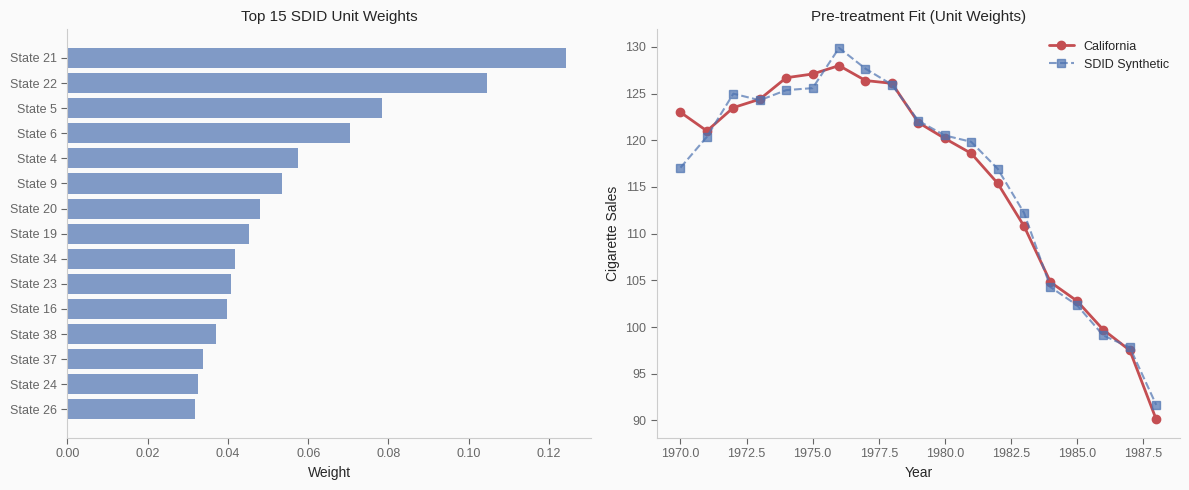


Pre-treatment MSE: 2.9770


In [5]:
# Visualize unit weights
state_ids = Y_wide.index[Y_wide.index != calif_state].values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Weight distribution
ax = axes[0]
sorted_idx = np.argsort(w_hat)[::-1]
top_k = 15
ax.barh(range(top_k), w_hat[sorted_idx[:top_k]], color=COLORS['blue'], alpha=0.7)
ax.set_yticks(range(top_k))
ax.set_yticklabels([f"State {state_ids[i]}" for i in sorted_idx[:top_k]])
ax.set_xlabel('Weight')
ax.set_title(f'Top {top_k} SDID Unit Weights')
ax.invert_yaxis()
apply_tufte_style(ax)

# Right: Pre-treatment fit
ax = axes[1]
synth_pre = w0_hat + X_unit @ w_hat
ax.plot(pre_years, y_unit, 'o-', color=COLORS['red'], label='California', linewidth=2)
ax.plot(pre_years, synth_pre, 's--', color=COLORS['blue'], 
        label='SDID Synthetic', alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales')
ax.set_title('Pre-treatment Fit (Unit Weights)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Fit quality
pre_mse = np.mean((y_unit - synth_pre)**2)
print(f"\nPre-treatment MSE: {pre_mse:.4f}")

### Time Weight Estimation with cvxpy

In [6]:
def sdid_time_weights_cvxpy(Y_co_pre, Y_co_post):
    """
    Estimate SDID time weights using cvxpy.
    
    Find weights on pre-periods that best predict post-period mean for controls.
    
    Parameters
    ----------
    Y_co_pre : ndarray (N_co, T_pre)
        Control outcomes in pre-period
    Y_co_post : ndarray (N_co, T_post)
        Control outcomes in post-period
        
    Returns
    -------
    lambda0 : float
        Intercept
    lam : ndarray (T_pre,)
        Time weights
    """
    N_co, T_pre = Y_co_pre.shape
    
    # Target: post-period mean for each control
    y_target = Y_co_post.mean(axis=1)  # (N_co,)
    
    # Decision variables
    lam = cp.Variable(T_pre)
    lambda0 = cp.Variable()
    
    # Objective: MSE (no penalty for time weights)
    pred = lambda0 + Y_co_pre @ lam
    objective = cp.Minimize(cp.sum_squares(pred - y_target))
    
    # Constraints
    constraints = [
        cp.sum(lam) == 1,
        lam >= 0
    ]
    
    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    
    if prob.status != cp.OPTIMAL:
        raise ValueError(f"Optimization failed: {prob.status}")
    
    return lambda0.value, lam.value

# Estimate time weights
lambda0_hat, lambda_hat = sdid_time_weights_cvxpy(Y_co_pre, Y_co_post)

print(f"Time Weight Results:")
print(f"  Intercept (lambda0): {lambda0_hat:.4f}")
print(f"  Non-zero weights: {np.sum(lambda_hat > 1e-4)}")
print(f"  Sum of weights: {np.sum(lambda_hat):.6f}")

Time Weight Results:
  Intercept (lambda0): -15.0239
  Non-zero weights: 3
  Sum of weights: 1.000000


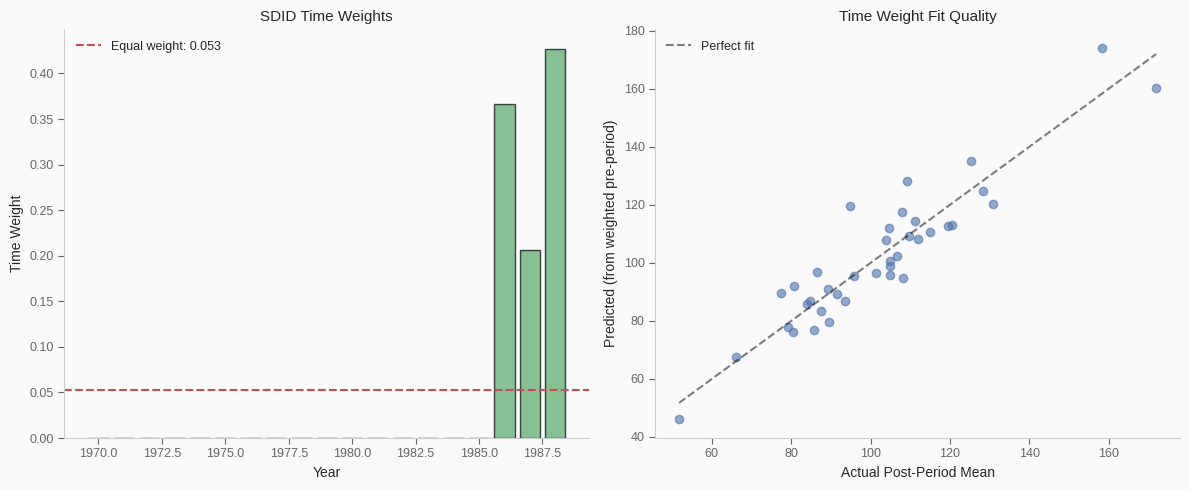


Time weight prediction R²: 0.8466


In [7]:
# Visualize time weights
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Time weight distribution
ax = axes[0]
ax.bar(pre_years, lambda_hat, color=COLORS['green'], alpha=0.7, edgecolor='black')
ax.axhline(1/T_pre, color=COLORS['red'], linestyle='--', 
           label=f'Equal weight: {1/T_pre:.3f}')
ax.set_xlabel('Year')
ax.set_ylabel('Time Weight')
ax.set_title('SDID Time Weights')
ax.legend()
apply_tufte_style(ax)

# Right: Prediction fit for controls
ax = axes[1]
y_target = Y_co_post.mean(axis=1)
y_pred = lambda0_hat + Y_co_pre @ lambda_hat

ax.scatter(y_target, y_pred, alpha=0.6, color=COLORS['blue'])
ax.plot([y_target.min(), y_target.max()], [y_target.min(), y_target.max()], 
        'k--', alpha=0.5, label='Perfect fit')
ax.set_xlabel('Actual Post-Period Mean')
ax.set_ylabel('Predicted (from weighted pre-period)')
ax.set_title('Time Weight Fit Quality')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# R-squared
ss_res = np.sum((y_target - y_pred)**2)
ss_tot = np.sum((y_target - y_target.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"\nTime weight prediction R²: {r2:.4f}")

---

## 4. Implementation {#implementation}

### Full SDID Estimator

In [8]:
class SDIDEstimator:
    """
    Synthetic Difference-in-Differences estimator.
    
    Implements Arkhangelsky et al. (2021) using cvxpy for weight estimation.
    """
    
    def __init__(self, zeta=None):
        """
        Parameters
        ----------
        zeta : float, optional
            Regularization parameter. If None, computed from data.
        """
        self.zeta = zeta
        self.w0_ = None
        self.w_ = None
        self.lambda0_ = None
        self.lambda_ = None
        self.tau_ = None
        
    def _compute_zeta(self, Y_co_pre, N_tr, T_post):
        """Compute regularization parameter from data."""
        delta = np.diff(Y_co_pre, axis=1)
        sigma = np.std(delta, ddof=1)
        return (N_tr * T_post) ** 0.25 * sigma
    
    def _estimate_unit_weights(self, X, y, zeta, T_pre):
        """Estimate unit weights via cvxpy."""
        N_co = X.shape[1]
        w = cp.Variable(N_co)
        w0 = cp.Variable()
        
        pred = w0 + X @ w
        objective = cp.Minimize(
            cp.sum_squares(pred - y) + zeta**2 * T_pre * cp.sum_squares(w)
        )
        constraints = [cp.sum(w) == 1, w >= 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, verbose=False)
        
        return w0.value, w.value
    
    def _estimate_time_weights(self, Y_co_pre, Y_co_post):
        """Estimate time weights via cvxpy."""
        N_co, T_pre = Y_co_pre.shape
        y_target = Y_co_post.mean(axis=1)
        
        lam = cp.Variable(T_pre)
        lambda0 = cp.Variable()
        
        pred = lambda0 + Y_co_pre @ lam
        objective = cp.Minimize(cp.sum_squares(pred - y_target))
        constraints = [cp.sum(lam) == 1, lam >= 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, verbose=False)
        
        return lambda0.value, lam.value
    
    def fit(self, Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post):
        """
        Fit the SDID estimator.
        
        Parameters
        ----------
        Y_tr_pre : ndarray (T_pre,) or (N_tr, T_pre)
            Treated unit(s) pre-treatment outcomes
        Y_tr_post : ndarray (T_post,) or (N_tr, T_post)
            Treated unit(s) post-treatment outcomes
        Y_co_pre : ndarray (N_co, T_pre)
            Control units pre-treatment outcomes
        Y_co_post : ndarray (N_co, T_post)
            Control units post-treatment outcomes
        """
        # Ensure correct shapes
        Y_tr_pre = np.atleast_1d(Y_tr_pre).flatten()
        Y_tr_post = np.atleast_1d(Y_tr_post).flatten()
        
        N_co, T_pre = Y_co_pre.shape
        T_post = Y_co_post.shape[1]
        N_tr = 1  # Currently supports single treated unit
        
        # Compute zeta if not provided
        if self.zeta is None:
            self.zeta = self._compute_zeta(Y_co_pre, N_tr, T_post)
        
        # Estimate unit weights
        X_unit = Y_co_pre.T  # (T_pre, N_co)
        self.w0_, self.w_ = self._estimate_unit_weights(
            X_unit, Y_tr_pre, self.zeta, T_pre
        )
        
        # Estimate time weights
        self.lambda0_, self.lambda_ = self._estimate_time_weights(
            Y_co_pre, Y_co_post
        )
        
        # Compute SDID estimate
        # Post difference
        Y_tr_post_mean = Y_tr_post.mean()
        Y_co_post_weighted = (Y_co_post.T @ self.w_).mean()
        
        # Pre difference (time-weighted)
        Y_tr_pre_weighted = Y_tr_pre @ self.lambda_
        Y_co_pre_weighted = (Y_co_pre.T @ self.w_) @ self.lambda_
        
        # Double difference
        self.tau_ = (Y_tr_post_mean - Y_co_post_weighted) - \
                    (Y_tr_pre_weighted - Y_co_pre_weighted)
        
        return self
    
    @property
    def ate(self):
        """Average treatment effect estimate."""
        return self.tau_

In [9]:
# Use the estimator
sdid = SDIDEstimator()
sdid.fit(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post)

print(f"SDID Estimate: {sdid.ate:.2f} packs/capita")
print(f"")
print(f"Estimated parameters:")
print(f"  Regularization (zeta): {sdid.zeta:.4f}")
print(f"  Unit intercept (w0): {sdid.w0_:.4f}")
print(f"  Non-zero unit weights: {np.sum(sdid.w_ > 1e-4)}")
print(f"  Time intercept (lambda0): {sdid.lambda0_:.4f}")
print(f"  Non-zero time weights: {np.sum(sdid.lambda_ > 1e-4)}")

SDID Estimate: -15.61 packs/capita

Estimated parameters:
  Regularization (zeta): 10.2262
  Unit intercept (w0): -24.7504
  Non-zero unit weights: 27
  Time intercept (lambda0): -15.0239
  Non-zero time weights: 3


### Comparison: SDID vs DiD vs SC

In [10]:
# DiD estimate (equal weights)
tau_did = (Y_tr_post.mean() - Y_tr_pre.mean()) - \
          (Y_co_post.mean() - Y_co_pre.mean())

# SC estimate (unit weights only, no time weights)
def sc_estimate(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post):
    X = Y_co_pre.T
    y = Y_tr_pre
    N_co = X.shape[1]
    
    w = cp.Variable(N_co)
    objective = cp.Minimize(cp.sum_squares(X @ w - y))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    
    w_sc = w.value
    Y_synth_post = Y_co_post.T @ w_sc
    return Y_tr_post.mean() - Y_synth_post.mean()

tau_sc = sc_estimate(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post)

print(f"\n" + "="*50)
print(f"ESTIMATOR COMPARISON")
print(f"="*50)
print(f"DiD:  {tau_did:.2f} packs/capita")
print(f"SC:   {tau_sc:.2f} packs/capita")
print(f"SDID: {sdid.ate:.2f} packs/capita")
print(f"="*50)


ESTIMATOR COMPARISON
DiD:  -27.35 packs/capita
SC:   -19.51 packs/capita
SDID: -15.61 packs/capita


### Sensitivity to Regularization

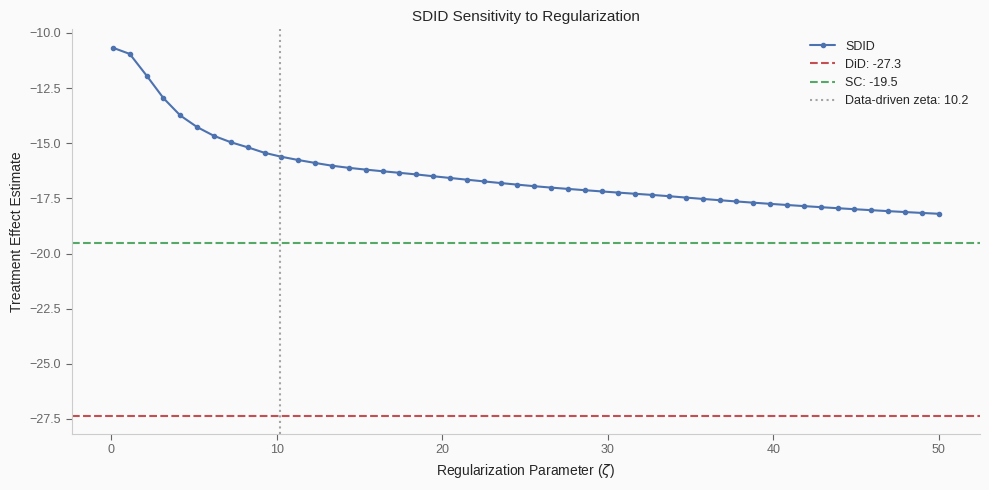


Key Insight: As zeta increases, SDID converges toward DiD (uniform weights).
As zeta decreases, SDID converges toward SC (sparse weights).


In [11]:
# How does tau change with different zeta values?
zeta_grid = np.linspace(0.1, 50, 50)
tau_grid = []

for z in zeta_grid:
    sdid_z = SDIDEstimator(zeta=z)
    sdid_z.fit(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post)
    tau_grid.append(sdid_z.ate)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zeta_grid, tau_grid, 'o-', color=COLORS['blue'], markersize=3, label='SDID')
ax.axhline(tau_did, color=COLORS['red'], linestyle='--', label=f'DiD: {tau_did:.1f}')
ax.axhline(tau_sc, color=COLORS['green'], linestyle='--', label=f'SC: {tau_sc:.1f}')
ax.axvline(sdid.zeta, color='gray', linestyle=':', alpha=0.7, 
           label=f'Data-driven zeta: {sdid.zeta:.1f}')

ax.set_xlabel(r'Regularization Parameter ($\zeta$)')
ax.set_ylabel('Treatment Effect Estimate')
ax.set_title('SDID Sensitivity to Regularization')
ax.legend(loc='best')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print(f"\nKey Insight: As zeta increases, SDID converges toward DiD (uniform weights).")
print(f"As zeta decreases, SDID converges toward SC (sparse weights).")

---

## 5. Interview Appendix {#interview}

### Q1: Why does SDID use an intercept in the unit weight problem?

<details>
<summary>Solution</summary>

**Key points:**

1. **Level shift flexibility**: The intercept $w_0$ allows a constant shift between
   treated and synthetic control. This is important because:
   - SC without intercept forces exact level matching
   - SDID with intercept allows different levels, focuses on matching *changes*

2. **Connection to DiD**: DiD implicitly has an intercept (unit fixed effects).
   The SDID intercept maintains this feature.

3. **Reduced sensitivity**: Without intercept, weights must compensate for level
   differences. With intercept, weights focus on trend matching.

</details>

### Q2: Explain the L2 penalty in SDID unit weights. Why not L1?

<details>
<summary>Solution</summary>

**Key points:**

1. **L2 (Ridge) properties**:
   - Shrinks weights toward uniformity (DiD-like)
   - All weights remain non-zero
   - Smooth interpolation between SC and DiD

2. **Why not L1 (Lasso)?**:
   - L1 would encourage sparsity (few non-zero weights)
   - Already constrained to simplex (sum=1, non-negative)
   - L2 + simplex gives desired interpolation behavior

3. **Theoretical motivation**:
   - L2 penalty ensures weights are "spread out" when zeta is large
   - This recovers DiD in the limit (all controls weighted equally)

</details>

### Q3: What is the role of time weights in SDID?

<details>
<summary>Solution</summary>

**Key points:**

1. **Purpose**: Find pre-treatment periods that best predict post-treatment
   outcomes for control units.

2. **Why this matters**:
   - Not all pre-periods are equally informative
   - Some periods may be outliers or structurally different
   - Time weights emphasize "relevant" pre-periods

3. **Connection to parallel trends**:
   - If parallel trends hold exactly, all pre-periods are equally informative
   - Time weights adapt when some periods are more/less relevant
   - This makes SDID more robust to partial parallel trends violations

</details>

---

## 6. References {#references}

[^1]: Arkhangelsky, D., Athey, S., Hirshberg, D., Imbens, G., & Wager, S. (2021). 
      Synthetic Difference-in-Differences. *American Economic Review*, 111(12), 4088-4118.

[^2]: Boyd, S., & Vandenberghe, L. (2004). *Convex Optimization*. Cambridge University Press.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 25.